In [1]:
import numpy as np
import matplotlib.pyplot as plt
from probDE.car import car_init
from probDE.utils.utils import rand_mat, indep_init
from scipy.integrate import odeint
from probDE.cython.KalmanODE import KalmanODE as KalmanODE_blas
from probDE.tests.KalmanODE import KalmanODE
from KalmanODE_py import KalmanODE_py
%load_ext Cython

In [2]:
%%cython
from libc.math cimport sin
cpdef ode_fun(double[::1] x_out, double[::1] x, double t, tuple theta):
    x_out[0] = sin(2*t) - x[0]
    return


In [20]:
import numba
from math import sin
def f(x_t, t):
    return [x_t[1], sin(2*t) - x_t[0]]

numba_f = numba.jit(f)

In [21]:
# LHS vector of ODE
w_mat = np.array([[0.0, 0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_obs = 1
n_deriv = 4
n_deriv_var = [4]

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 100
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = [300]
sigma = [.5]

# Initial value, x0, for the IVP
x0 = np.array([[-1., 0., 1.]])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# All necessary parameters are in kinit, namely, T, c, R, W
kinit, W, x0_state = indep_init(car_init(n_deriv_var, tau, sigma, dt, x0), w_mat, n_deriv)

In [22]:
z_states = rand_mat(2*(n_eval+1), n_deriv)
kalmanode = KalmanODE_blas(n_deriv, n_obs, tmin, tmax, n_eval, ode_fun, **kinit)
kalmanode.z_states = z_states
kalman_sim, _, _ = kalmanode.solve(x0_state, W, mv=True, sim=True)

In [23]:
kalmanode_py = KalmanODE_py(n_deriv, n_obs, tmin, tmax, n_eval, ode_fun, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
k_sim, k_mu, k_var = kalmanode_py.solve(x0_state, W, mv=True, sim=True)

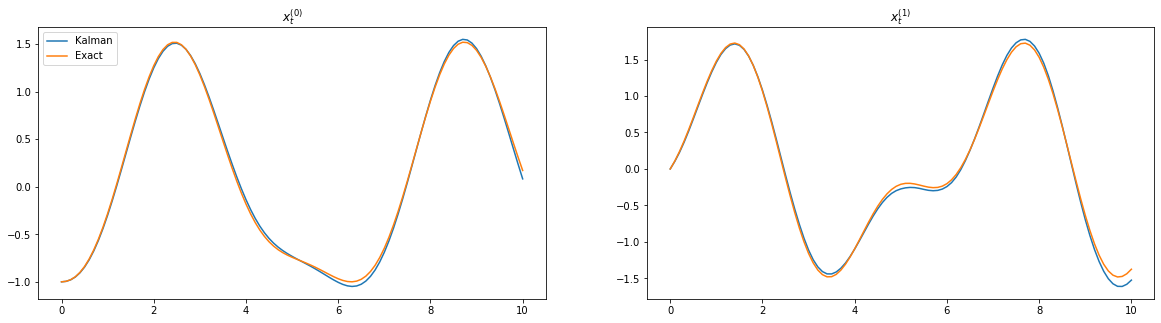

In [24]:
# ode function in odeint format
tseq = np.linspace(tmin, tmax, n_eval+1)
ode = odeint(f, [-1, 0], tseq)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, kalman_sim[:,0], label = 'Kalman')
axs[0].plot(tseq, ode[:, 0], label = 'Exact')
axs[0].set_title("$x^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, kalman_sim[:,1], label = 'Kalman')
axs[1].plot(tseq, ode[:, 1], label = 'Exact')
axs[1].set_title("$x^{(1)}_t$")
plt.show()

In [32]:
kalmanode = KalmanODE(n_deriv, n_obs, tmin, tmax, n_eval, ode_fun, **kinit) # Initialize the class
kalmanode.z_states = z_states
kalman_c = %timeit -o _ = kalmanode.solve(x0_state, W, mv=False, sim=True)

484 µs ± 6.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [33]:
kalmanode = KalmanODE_blas(n_deriv, n_obs, tmin, tmax, n_eval, ode_fun, **kinit) # Initialize the class
kalmanode.z_states = z_states
kalman_cy = %timeit -o -n 100 _ = kalmanode.solve(x0_state, W, mv=False, sim=True)

1.41 ms ± 53.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
kalmanode_py = KalmanODE_py(n_deriv, n_obs, tmin, tmax, n_eval, ode_fun, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_py = %timeit -o _ = kalmanode_py.solve(x0_state, W, mv=False, sim=True)

12.4 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
tseq = np.linspace(tmin, tmax, n_eval+1)
ode = %timeit -o ode = odeint(numba_f, [-1, 0], tseq)

481 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [36]:
print("Cython is {}x faster than Python".format(kalman_py.average/kalman_cy.average))
print("C++ is {}x faster than Python".format(kalman_py.average/kalman_c.average))
print("ode is {}x faster than Python".format(kalman_py.average/ode.average))

Cython is 8.777869794599033x faster than Python
C++ is 25.678429150114027x faster than Python
ode is 25.813260384151906x faster than Python


## Lorenz63

In [37]:
%%cython
# RHS of ODE
import numpy as np
cimport numpy as np
cpdef lorenz(double[::1] X_out, double[::1] X, double t, tuple theta):
    rho, sigma, beta = theta
    cdef int p = len(X)//3
    x, y, z = X[p*0], X[p*1], X[p*2]
    X_out[0] = -sigma*x + sigma*y
    X_out[1] = rho*x - y -x*z
    X_out[2] = -beta*z + x*y
    return 

In [38]:
def lorenz0(X, t, theta):
    rho, sigma, beta = theta
    p = len(X)//3
    x, y, z = X[p*0], X[p*1], X[p*2]
    return -sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y

numba_lorenz = numba.jit(lorenz0)

In [80]:
# LHS Matrix of ODE
w_mat = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_obs = 3
n_deriv = 9 # number of continuous derivatives of CAR(p) solution prior
n_deriv_var = [3, 3, 3]

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 3000
tmin = 0
tmax = 20
theta = (28, 10, 8/3)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = np.array([10, 10, 10])
sigma = np.array([.5, .5, .5])

# Initial value, x0, for the IVP
x0 = [-12, -5, 38]
v0 = [70, 125, -124/3]
x0 = np.column_stack([x0, v0])

In [81]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
kinit, W, x0_state = indep_init(car_init(n_deriv_var, tau, sigma, dt, x0), w_mat, n_deriv)

# Initialize the Kalman class
kalmanode = KalmanODE(n_deriv, n_obs, tmin, tmax, n_eval, lorenz, **kinit)
# Run the solver to get an approximation
kalman_lor_sim = kalmanode.solve(x0_state, W, theta, mv=False, sim=True)

In [82]:
z_states = rand_mat(2*(n_eval+1), n_deriv)
kalmanode_py = KalmanODE_py(n_deriv, n_obs, tmin, tmax, n_eval, lorenz, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_lor_py = %timeit -o _ = kalmanode_py.solve(x0_state, W, theta, mv=False, sim=True)
kalmanode_c = KalmanODE(n_deriv, n_obs, tmin, tmax, n_eval, lorenz, **kinit) # Initialize the class
kalmanode_c.z_states = z_states
kalman_lor_c = %timeit -o _ = kalmanode_c.solve(x0_state, W, theta, mv=False, sim=True)
kalmanode = KalmanODE_blas(n_deriv, n_obs, tmin, tmax, n_eval, lorenz, **kinit)
kalmanode.z_states = z_states
kalman_lor_cy = %timeit -o _ = kalmanode.solve(x0_state, W, theta, mv=False, sim=True)
tseq = np.linspace(tmin, tmax, n_eval+1)
ode_lorenz = %timeit -o ode = odeint(numba_lorenz, x0[:, 0], tseq, args=(theta,))
print('py/cy: {}'.format(kalman_lor_py.average/kalman_lor_cy.average))
print('py/c: {}'.format(kalman_lor_py.average/kalman_lor_c.average))
print('py/ode: {}'.format(kalman_lor_py.average/ode_lorenz.average))

407 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
32.8 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
54 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.1 ms ± 243 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
py/cy: 7.533432396986899
py/c: 12.425415201301513
py/ode: 40.27467828486966


In [83]:
tseq = np.linspace(tmin, tmax, n_eval+1)
ode_lorenz = odeint(numba_lorenz, x0[:, 0], tseq, args=(theta,))

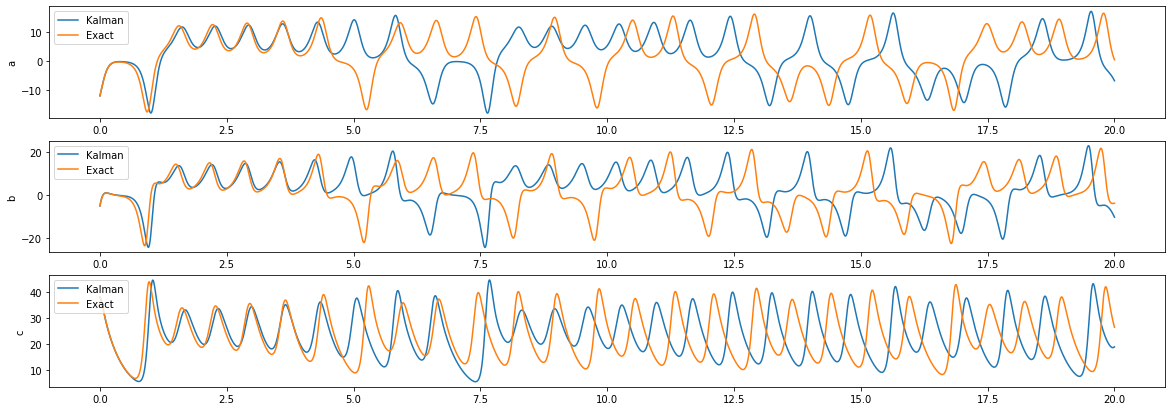

In [84]:
_, axs = plt.subplots(n_obs, 1, figsize=(20, 7))
ylabel = ['a', 'b', 'c']
for i in range(n_obs):
    axs[i].plot(tseq, kalman_lor_sim[:, n_deriv_var[0]*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, ode_lorenz[:, i], label='Exact')
    axs[i].legend(loc='upper left')

# Fitz model

In [85]:
%%cython
cpdef fitz(double[::1] X_out, double[::1] X, double t, tuple theta):
    "FitzHugh-Nagumo ODE function."
    a, b, c = theta
    cdef int n_deriv1 = len(X)//2
    V, R = X[0], X[n_deriv1]
    X_out[0] = c*(V - V**3/3 + R)
    X_out[1] = -1/c*(V - a + b*R)
    return

In [86]:
def fitz0(X, t, theta):
    "FitzHugh-Nagumo ODE function."
    a, b, c = theta
    n_deriv1 = len(X)//2
    V, R = X[0], X[n_deriv1]
    return c*(V - V*V*V/3 + R), -1/c*(V - a + b*R)

numba_fitz = numba.jit(fitz0)

In [87]:
n_deriv = 6 # Total state
n_deriv_var = [3, 3]
n_obs = 2 # Total measures
state_ind = [0, 3]

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0 
tmax = 40
#h = 0.1 # step size
#n_eval = int((tmax-tmin)/h)
n_eval = 600

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 2
tau = [100]*n_var
sigma = [.1]*n_var

# Initial value, x0, for the IVP
x0 = np.array([-1., 1.])
v0 = np.array([1, 1/3])
X0 = np.column_stack([x0, v0])
w_mat = np.array([[0.0, 1.0], [0.0, 1.0]])
theta = (0.2, 0.2, 3)


In [88]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
kinit, W, x0_state = indep_init(car_init(n_deriv_var, tau, sigma, dt, X0), w_mat, n_deriv)

# Initialize the Kalman class
kalmanode = KalmanODE_blas(n_deriv, n_obs, tmin, tmax, n_eval, fitz, **kinit)
z_states = rand_mat(2*(n_eval+1), n_deriv)
kalmanode.z_states = z_states
# Run the solver to get an approximation
kalman_fitz_sim = kalmanode.solve(x0_state, W, theta, mv=False, sim=True)

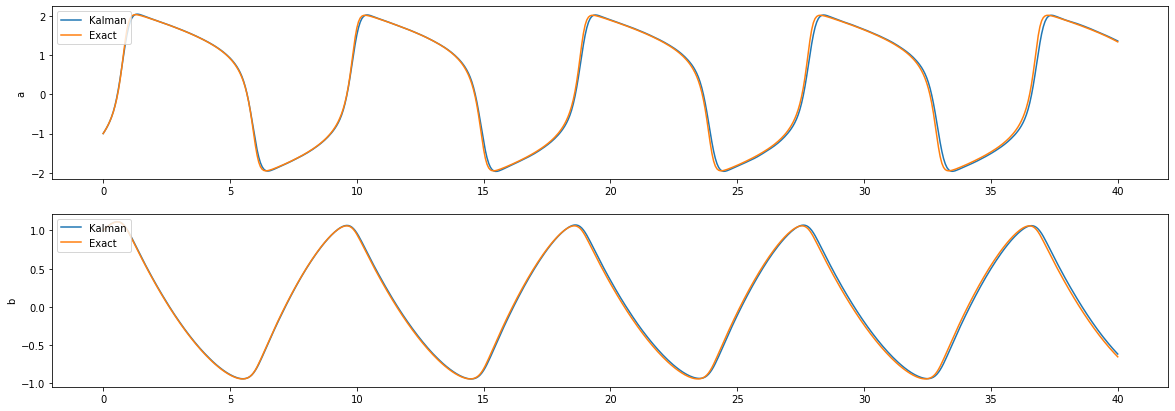

In [89]:
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(fitz0, X0[:, 0], tseq, args=(theta,))

_, axs = plt.subplots(n_obs, 1, figsize=(20, 7))
ylabel = ['a', 'b', 'c']
for i in range(n_obs):
    axs[i].plot(tseq, kalman_fitz_sim[:, n_deriv_var[0]*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [90]:
z_states = rand_mat(2*(n_eval+1), n_deriv)
kalmanode_c = KalmanODE(n_deriv, n_obs, tmin, tmax, n_eval, fitz, **kinit) # Initialize the class
kalmanode_c.z_states = z_states
kalman_fitz_c = %timeit -o _ = kalmanode_c.solve(x0_state, W, theta, mv=False, sim=True)
kalmanode = KalmanODE_blas(n_deriv, n_obs, tmin, tmax, n_eval, fitz, **kinit)
kalmanode.z_states = z_states
kalman_fitz_cy = %timeit -o _ = kalmanode.solve(x0_state, W, theta, mv=False, sim=True)
kalmanode_py = KalmanODE_py(n_deriv, n_obs, tmin, tmax, n_eval, fitz, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_fitz_py = %timeit -o _ = kalmanode_py.solve(x0_state, W, theta, mv=False, sim=True)
tseq = np.linspace(tmin, tmax, n_eval+1)
ode_fitz = %timeit -o ode =  odeint(numba_fitz, X0[:, 0], tseq, args=(theta,))
print('py/cy: {}'.format(kalman_fitz_py.average/kalman_fitz_cy.average))
print('py/c: {}'.format(kalman_fitz_py.average/kalman_fitz_c.average))
print('py/ode: {}'.format(kalman_fitz_py.average/ode_fitz.average))

4.35 ms ± 29.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.12 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
77.1 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.82 ms ± 321 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
py/cy: 8.459593427982684
py/c: 17.738868318847548
py/ode: 16.011884101655635


# MSEIR model

We will look at a multivariate ODE system called **MSEIR model**. This model is used in epidemiology where<br/>
M = Maternally-derived Immunity<br/>
S = Susceptible<br/>
E = Exposed<br/>
I = Infectious<br/>
R = Recovered<br/>

\begin{equation}
  \begin{aligned}
    \frac{dM}{dt} &= \Lambda - \delta M - \mu M \\
    \frac{dS}{dt} &= \delta M- \frac{\beta SI}{N} - \mu S \\
    \frac{dE}{dt} &= \frac{\beta SI}{N} - (\epsilon + \mu)E \\
    \frac{dI}{dt} &= \epsilon E - (\gamma + \mu)I \\
    \frac{dR}{dt} &= \gamma I - \mu R
  \end{aligned}
\end{equation}


In [91]:
%%cython
cpdef mseir(double[::1] X_out, double[::1] X, double t, tuple theta):
    cdef int p = len(X)//5
    M, S, E, I, R = X[::p]
    cdef int N = M+S+E+I+R
    Lambda, delta, beta, mu, epsilon, gamma = theta
    X_out[0] = Lambda - delta*M - mu*M
    X_out[1] = delta*M - beta*S*I/N - mu*S
    X_out[2] = beta*S*I/N - (epsilon + mu)*E
    X_out[3] = epsilon*E - (gamma + mu)*I
    X_out[4] = gamma*I - mu*R
    return

In [92]:
def mseir0(X_t, t, theta):
    "MSEIR ODE function"
    p = len(X_t)//5
    M, S, E, I, R = X_t[::p]
    N = M+S+E+I+R
    Lambda, delta, beta, mu, epsilon, gamma = theta
    dM = Lambda - delta*M - mu*M
    dS = delta*M - beta*S*I/N - mu*S
    dE = beta*S*I/N - (epsilon + mu)*E
    dI = epsilon*E - (gamma + mu)*I
    dR = gamma*I - mu*R
    return np.array([dM, dS, dE, dI, dR])

numba_mseir = numba.jit(mseir0)

In [105]:
# LHS Matrix of ODE
w_mat = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_obs = 5
n_deriv = 15 # number of continuous derivatives of CAR(p) solution prior
n_deriv_var = [3, 3, 3, 3, 3]

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 100
tmin = 0
tmax = 20
theta = (1, 0.7, 0.4, 0.005, 0.02, 0.035)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = np.array([10, 10, 10, 10, 10])
sigma = np.array([.5, .5, .5, .5, .5])

# Initial value, x0, for the IVP
x0 = np.array([1000, 100, 50, 3, 3])
v0 = mseir0(x0, 0, theta)
X0 = np.column_stack([x0, v0])

In [106]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
kinit, W, x0_state = indep_init(car_init(n_deriv_var, tau, sigma, dt, X0), w_mat, n_deriv)

# Initialize the Kalman class
kalmanode = KalmanODE_blas(n_deriv, n_obs, tmin, tmax, n_eval, mseir, **kinit)
z_states = rand_mat(2*(n_eval+1), n_deriv)
kalmanode.z_states = z_states
# Run the solver to get an approximation
kalman_mse_sim = kalmanode.solve(x0_state, W, theta, mv=False, sim=True)

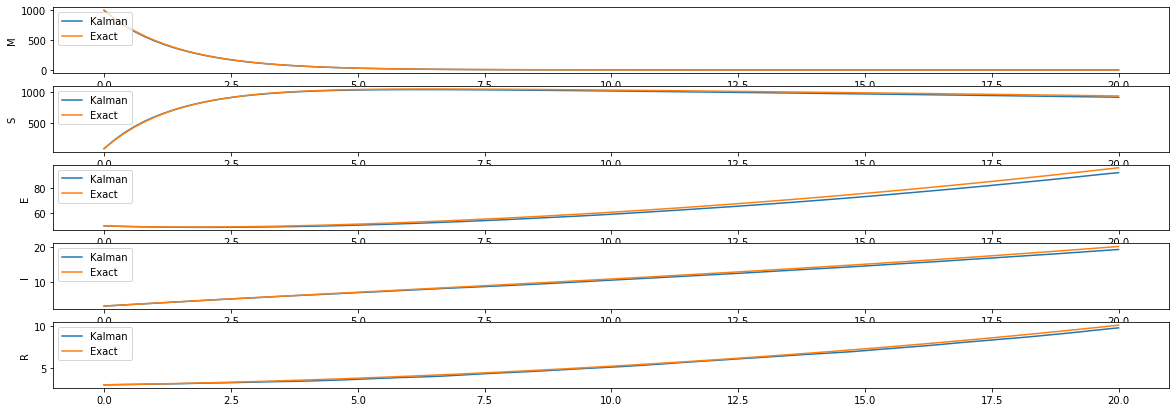

In [107]:
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(mseir0, X0[:, 0], tseq, args=(theta,))

_, axs = plt.subplots(n_obs, 1, figsize=(20, 7))
ylabel = ['M', 'S', 'E', 'I', 'R']
for i in range(n_obs):
    axs[i].plot(tseq, kalman_mse_sim[:, n_deriv_var[0]*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [108]:
z_states = rand_mat(2*(n_eval+1), n_deriv)
kalmanode_c = KalmanODE(n_deriv, n_obs, tmin, tmax, n_eval, mseir, **kinit) # Initialize the class
kalmanode_c.z_states = z_states
kalman_mse_c = %timeit -o _ = kalmanode_c.solve(x0_state, W, theta, mv=False, sim=True)
kalmanode = KalmanODE_blas(n_deriv, n_obs, tmin, tmax, n_eval, mseir, **kinit)
kalmanode.z_states = z_states
kalman_mse_cy = %timeit -o _ = kalmanode.solve(x0_state, W, theta, mv=False, sim=True)
kalmanode_py = KalmanODE_py(n_deriv, n_obs, tmin, tmax, n_eval, mseir, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_mse_py = %timeit -o _ = kalmanode_py.solve(x0_state, W, theta, mv=False, sim=True)
tseq = np.linspace(tmin, tmax, n_eval+1)
ode_mseir = %timeit -o ode =  odeint(numba_mseir, X0[:, 0], tseq, args=(theta,))
print('py/cy: {}'.format(kalman_mse_py.average/kalman_mse_cy.average))
print('py/c: {}'.format(kalman_mse_py.average/kalman_mse_c.average))
print('py/ode: {}'.format(kalman_mse_py.average/ode_mseir.average))

2.44 ms ± 62.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.05 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.5 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
334 µs ± 8.43 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
py/cy: 5.09163837898161
py/c: 6.363146963211748
py/ode: 46.449441260335604
